In [58]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Array layout

Internally, arrays are just big linear chunks of memory:

In [320]:
A = np.random.rand(3, 4)
A.data


In [298]:
data = A.reshape(-1)

data

A[1, 1]

0.6441726954781796

When `A.shape=(m, n)` and we type `A[i, j]`, Numpy calculates the position of the exact element in the array via the formula 

```A[i, j] = data[i * n + j]```

This works for higher dimensions as well: when we type `A[i0, i1, ..., ik]` the result is 
    
    data[i0 * strides[0] + i1 * strides[1] + ik * strides[k]]

In [98]:
m, n  = A.shape
i, j = 2, 3
A[i, j], data[i * n + j]

(0.1598254924930831, 0.1598254924930831)

This says that the first axis has "stride n" and the second axis has "stride j".

In [309]:
A.shape, A.strides

((3, 4), (32, 7))

What happens if we set the strides to something else?

In [333]:
A = np.random.rand(5)

data = A.reshape(-1).copy()

A.shape = (5, 5)
A.strides = (8, 8)

A

ValueError: cannot reshape array of size 5 into shape (5,5)

## Manipulating strides
- One area where this is useful is in creating different views of the array without consuming a lot of extra memory.
- For example, suppose we have a vector `v` and we wanted to compute a "windowed moving average":

In [350]:
v = np.random.rand(10)

w = np.lib.stride_tricks.as_strided(
    v,
    shape=(8, 3),
    strides=(8, 8)
)

w.mean(axis=1), np.convolve(v, np.ones(3) / 3, 'valid')

(array([0.61400771, 0.67662012, 0.73521241, 0.70537372, 0.90681121,
        0.91735298, 0.91753295, 0.75559265]),
 array([0.61400771, 0.67662012, 0.73521241, 0.70537372, 0.90681121,
        0.91735298, 0.91753295, 0.75559265]))

In [340]:
w = 3
np.convolve(v, np.ones(w) / w, 'valid')

array([0.46252391, 0.50137823, 0.48119665, 0.50216262, 0.3099761 ,
       0.46749768, 0.23192484, 0.37065382])

In [232]:
np.lib.stride_tricks.as_strided(
    v,
    shape=(8, 3),
    strides=(1 * 8, 1 * 8)
).mean(1)

array([0.31644059, 0.33266923, 0.27398903, 0.50439826, 0.53002619,
       0.5994584 , 0.5979133 , 0.6920072 ])

This works for 2d arrays as well:

In [355]:
A = np.random.rand(4, 4)

In [362]:
np.lib.stride_tricks.as_strided(
    A,
    shape=(3, 3, 2, 2),
    strides=(32, 8, 32, 8)
).shape

(3, 3, 2, 2)

# DIY convolution

In [363]:
import skimage

(300, 451, 3)

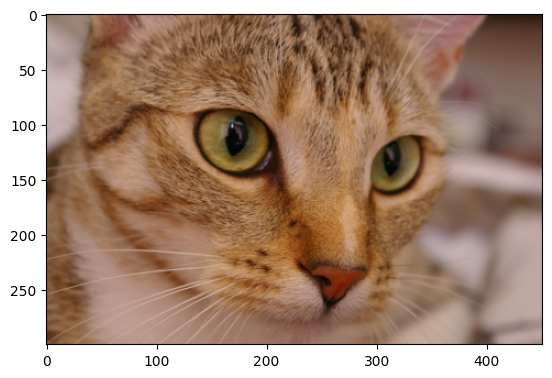

In [374]:
img = skimage.data.chelsea()

plt.imshow(img)

img.shape

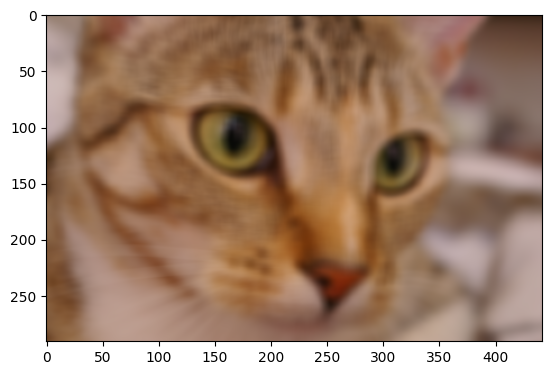

In [390]:
w = 10

windows = np.lib.stride_tricks.sliding_window_view(
    img, window_shape=(w, w), axis=(0, 1)
)

plt.imshow(windows.mean((-2, -1)) / 255) 

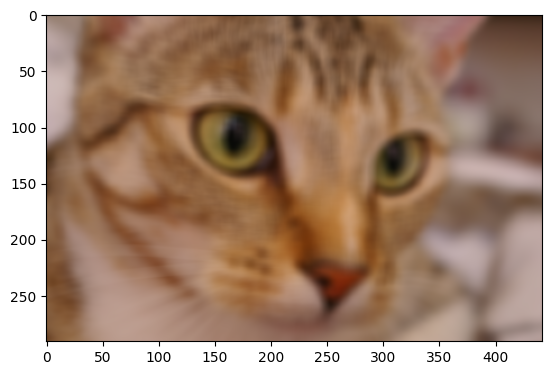

In [230]:
plt.imshow(windows.mean(axis=(3, 4)) / 255)

### Tiling without broadcasting

In [408]:
w = 10

W = np.ones((w, w))

C = np.lib.stride_tricks.as_strided(W, strides=(0, 0, 0) + W.strides, shape=windows.shape)

windows

array([[[[[143, 143, 141, ..., 143, 144, 145],
          [146, 145, 143, ..., 142, 144, 145],
          [148, 147, 146, ..., 143, 144, 146],
          ...,
          [163, 160, 160, ..., 153, 151, 152],
          [163, 160, 161, ..., 154, 154, 153],
          [166, 165, 166, ..., 158, 156, 155]],

         [[120, 120, 118, ..., 120, 121, 122],
          [123, 122, 120, ..., 119, 121, 122],
          [126, 125, 122, ..., 120, 121, 123],
          ...,
          [140, 137, 137, ..., 131, 129, 130],
          [143, 140, 138, ..., 132, 132, 131],
          [146, 145, 143, ..., 136, 134, 133]],

         [[104, 104, 102, ..., 104, 105, 106],
          [107, 106, 104, ..., 103, 105, 106],
          [112, 111, 109, ..., 104, 103, 105],
          ...,
          [132, 129, 129, ..., 118, 115, 116],
          [136, 133, 130, ..., 119, 118, 117],
          [139, 138, 135, ..., 125, 121, 120]]],


        [[[143, 141, 141, ..., 144, 145, 145],
          [145, 143, 142, ..., 144, 145, 146],
       

In [413]:
np.einsum('yxcij,yxcij->yxc', windows, C) / w ** 2 / 256

array([[[0.58769531, 0.49996094, 0.44886719],
        [0.58507813, 0.49707031, 0.44410156],
        [0.58324219, 0.49496094, 0.44011719],
        ...,
        [0.21472656, 0.1359375 , 0.08699219],
        [0.21441406, 0.13609375, 0.08675781],
        [0.21460937, 0.13589844, 0.08671875]],

       [[0.59605469, 0.50886719, 0.46082031],
        [0.59289063, 0.50535156, 0.45527344],
        [0.59042969, 0.50253906, 0.45042969],
        ...,
        [0.22402344, 0.14367188, 0.09382812],
        [0.22382812, 0.14378906, 0.09367188],
        [0.22417969, 0.14355469, 0.09382812]],

       [[0.60492188, 0.51828125, 0.4734375 ],
        [0.60125   , 0.51417969, 0.46722656],
        [0.59824219, 0.51074219, 0.46167969],
        ...,
        [0.23398437, 0.1515625 , 0.10140625],
        [0.23394531, 0.15152344, 0.10132813],
        [0.23433594, 0.15109375, 0.10160156]],

       ...,

       [[0.39195313, 0.2471875 , 0.13683594],
        [0.40773437, 0.25964844, 0.14757813],
        [0.42339844, 0

## Einstein summation
  - Indices appearing twice are summed over.
  - Example: `ij,jk->ik` represents matrix multiplication.

#### Example: matrix multiplication

- $C = A B$ means 

$$C_{ij} = \sum_k A_{ik} B_{kj}$$

In [414]:
M, N, K = 5, 10, 11
A = np.random.rand(M, K)
B = np.random.rand(K, N)
C = A @ B
assert C.shape == (M, N)

In [426]:
np.isclose(
    np.einsum('ik,kj->ij', A, B) - A @ B,
    0.
).all()

True

#### Example: Matrix transpose

In [444]:
C = np.random.rand(3, 4, 5)

C.transpose(0, 2, 1).strides

(160, 8, 40)

#### Example: Hadamard product

In [448]:
A ** 2

np.einsum('ij,ij->', A, A)

16.069867860421468

#### Example: summing out a column/row

In [452]:
np.einsum('ij->i', A), A.sum(1)

(array([3.73584906, 5.77246344, 6.14419136, 4.63421386, 4.72263695]),
 array([3.73584906, 5.77246344, 6.14419136, 4.63421386, 4.72263695]))

#### Example: dot product

In [454]:
A[0].dot(A[1])

np.einsum('i,i->', A[0], A[1])

2.182013313934439

#### Example: batch matrix multiply

In [466]:
N = 100
K = 50
M = 30
B = 1000

A = np.random.rand(N, K)
Bb = np.random.rand(M, B, K)
# (A @ Bb).shape == (B, N, M)

np.einsum('nk,mbk->mbn', A, Bb)

array([[[ 9.88502624,  8.75910951, 10.17556612, ...,  9.5675995 ,
         10.54583152,  9.71393506],
        [10.8438409 , 11.508111  , 11.34556467, ..., 11.82437999,
         11.84008116, 12.6226759 ],
        [12.24744843, 12.73199348, 12.0825617 , ..., 12.0643761 ,
         13.5104735 , 12.00801016],
        ...,
        [ 9.79931399, 12.0519612 , 11.71811497, ..., 11.8878527 ,
         11.81635961, 13.82580493],
        [10.51437712, 12.01872097, 12.03236781, ..., 11.80601834,
         12.64689204, 13.0098041 ],
        [12.18595722, 11.94483479, 11.27683502, ..., 12.26022874,
         13.24992455, 11.85571004]],

       [[10.51516493, 11.58549214, 10.30762102, ..., 10.62194568,
         12.28615068, 11.55633471],
        [11.05022544, 11.69073096, 11.43943577, ..., 10.74097237,
         13.72635909, 11.77221637],
        [11.00857055, 12.32412448, 11.23085661, ..., 11.62814391,
         12.65371736, 12.41421435],
        ...,
        [10.59413128, 11.42607893, 10.75355443, ..., 1

1.06 s ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit np.einsum('nk,bkm->bnm', A, Bb)

#### Optimized einsum

- `einsum` will intelligently figure out the optimal way to multiply complex tensor contractions together

In [469]:
A = np.random.rand(1000, 2000)
B = np.random.rand(2000, 3000)
v = np.random.rand(3000)

%timeit A @ (B @ v)

621 µs ± 71.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [470]:
print(np.einsum_path('ij,jk,k->i', A, B, v)[1])

  Complete contraction:  ij,jk,k->i
         Naive scaling:  3
     Optimized scaling:  2
      Naive FLOP count:  1.800e+10
  Optimized FLOP count:  1.600e+07
   Theoretical speedup:  1125.000
  Largest intermediate:  2.000e+03 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   2                     k,jk->j                                  ij,j->i
   2                     j,ij->i                                     i->i


#### Einsum for batching

If your computations are written in `einsum`, batching becomes trivial. Example: multi-head self-attenion:

In [494]:
batch_size = 100
seq_length = 50
model_dim = 16
num_heads = 4

X = np.random.rand(batch_size, seq_length, model_dim)
W_q, W_k, W_v, W_o = np.random.rand(4, model_dim, model_dim)

batch_size, seq_length, model_dim = X.shape
assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"
head_dim = model_dim // num_heads

Q = np.einsum('bsd,df->bsf', X, W_q)  # queries
K = np.einsum('bsd,df->bsf', X, W_k)  # keys
V = np.einsum('bsd,df->bsf', X, W_v)  # values

Q.shape

(100, 50, 16)

In [498]:
Q, K, V = [x.reshape(batch_size, seq_length, num_heads, head_dim) for x in (Q, K, V)]

# scaled dot-product attention
# Attention scores: (batch_size, num_heads, seq_length, seq_length)

# softmax(Q K.T)

scores = np.einsum('bhqd,bhkd->bhqk', Q, K) / np.sqrt(head_dim)

import scipy.special
weights = scipy.special.softmax(scores, axis=-1)

# Compute attention output
context = np.einsum('bhqk,bhkd->bhqd', weights, V)

# Concatenate heads and reshape
context = context.transpose(0, 2, 1, 3).reshape(batch_size, seq_length, model_dim)

# Final linear projection
output = np.einsum('bsd,df->bsf', context, W_o)

output

array([[[31.05416598, 21.7787598 , 27.88708111, ..., 30.06231888,
         23.21208499, 27.22631261],
        [29.98019427, 21.93559759, 29.06526594, ..., 29.87348137,
         22.89026581, 28.37783948],
        [31.26005657, 19.9987163 , 28.00404847, ..., 29.65842599,
         22.64741784, 26.86184926],
        ...,
        [31.39780367, 21.51499466, 28.93477569, ..., 30.94147952,
         24.50024086, 28.71262623],
        [33.06337385, 20.89298546, 30.67481723, ..., 30.49994446,
         23.73977361, 29.28490647],
        [30.83852563, 22.48093679, 28.78510064, ..., 30.70847283,
         23.64552054, 27.97756678]],

       [[34.97754803, 23.96819881, 32.89476462, ..., 33.98282481,
         26.09278687, 31.76108973],
        [33.01141165, 23.35998851, 31.72019341, ..., 32.0420812 ,
         25.52247291, 30.89064977],
        [31.46408121, 22.70690721, 29.49154913, ..., 30.98540125,
         24.69634571, 28.95096198],
        ...,
        [33.70739356, 23.24764307, 32.05444454, ..., 3

#### TCGA example from book

In [52]:
import bz2
import pandas as pd

# Import TCGA melanoma data
filename = 'tgca_counts.txt.bz2'
with bz2.open(filename, mode='rt') as f:
    data_table = pd.read_csv(f, index_col=0)  # Parse file with pandas

print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


### Quantile nomalization

From Wikipedia:
    
- To quantile-normalize a test distribution to a reference distribution of the same length, sort the test distribution and sort the reference distribution.
- The highest entry in the test distribution then takes the value of the highest entry in the reference distribution.
- The next highest entry in the reference distribution, and so on, until the test distribution is a perturbation of the reference distribution.

In [53]:
counts = data_table.to_numpy()
counts.shape

(20500, 375)

In [54]:
# reference distribution quantiles
ref = np.mean(np.sort(counts, axis=0), axis=1)

In [55]:
# rank each observation by column
r = counts.argsort(axis=0)

In [56]:
counts_norm = ref[r]

In [260]:
def plot_col_density(data):
    """For each column, produce a density plot over all rows."""

    # Use Gaussian smoothing to estimate the density
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per column)')
    ax.set_ylabel('Density')


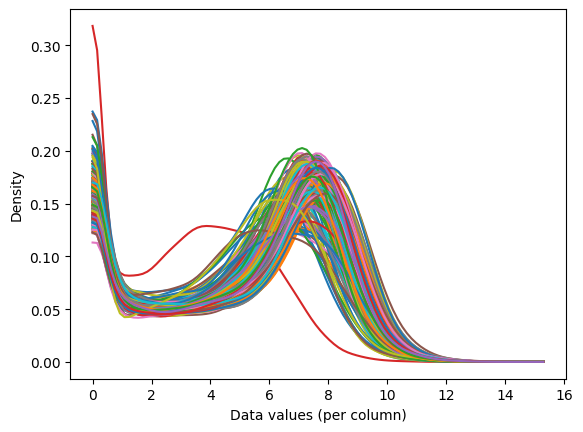

In [61]:
# Before normalization
log_counts = np.log1p(counts)
plot_col_density(log_counts)

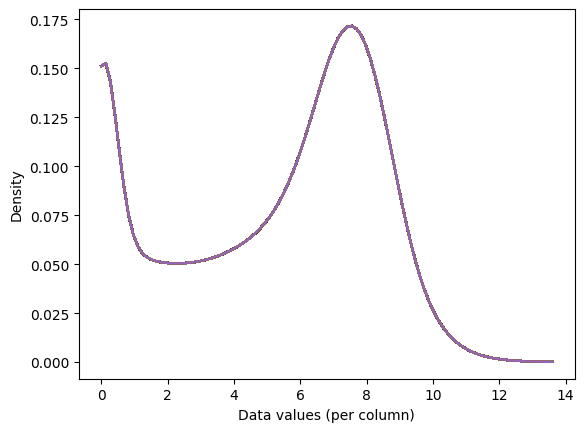

In [62]:
# Before normalization
plot_col_density(np.log1p(counts_norm))

## Biclustering

In [66]:
n = 1000
# find n most variable rows
rowvar = np.var(counts, axis=1)
# Get sorted indices (ascending order), take the last n
sort_indices = np.argsort(rowvar)[-n:]
# use as index for data
variable_data = counts[sort_indices, :]

In [ ]:
from scipy.cluster.hierarchy import linkage

y_rows = linkage(variableSdata, method=linkage_method, metric=distance_metric)
y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
return y_rows, y_cols